In [74]:
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import pandas as pd
import contractions
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import SimpleRNN, Embedding, GRU, Dense, LSTM

In [2]:
df = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/common-e8332.appspot.com/o/Restaurant_Reviews.tsv?alt=media&token=e8c70b99-384c-4feb-a280-9d12dcf8b58c', sep='\t')
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [3]:
reviews = np.array(df['Review'])
labels = np.array(df['Liked'])

In [4]:
lemmatizer = WordNetLemmatizer()
# Preprocessing
def preprocess_review(review):

    review = contractions.fix(review)
    
    # Convert to lowercase
    review = review.lower()
    
    # Tokenize
    tokens = word_tokenize(review)
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    important_stop_words = {
    "not",   # Crucial for negation
    "no",    # Important for negation
    "very",  # Intensifies sentiment
    "too",   # Can indicate excess or negativity
    "just"}  # Often used to soften statements

    
    # Remove stopwords
    stop_words = set(stopwords.words('english')) - important_stop_words
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
cleaned_reviews = []
# Process each review
for review in reviews:
    cleaned_reviews.append(preprocess_review(review))

In [7]:
cleaned_reviews[:5]

[['wow', '...', 'loved', 'place'],
 ['crust', 'not', 'good'],
 ['not', 'tasty', 'texture', 'just', 'nasty'],
 ['stopped',
  'late',
  'may',
  'bank',
  'holiday',
  'rick',
  'steve',
  'recommendation',
  'loved'],
 ['selection', 'menu', 'great', 'price']]

In [8]:
# Loading the embedding (It is better to download the file and import from the local directory)
model_path = 'https://firebasestorage.googleapis.com/v0/b/common-e8332.appspot.com/o/GoogleNews-vectors-negative300-SLIM.bin?alt=media&token=ce5beeda-f8b4-4d27-99b1-0098b6128372'

# Load the Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [10]:
# Adding special tokens to embedding

# Define the embedding size (for the GoogleNews vectors, it's 300)
embedding_size = word2vec_model.vector_size

# Initialize the <unk> and <pad> vectors (either zero or random)
unk_vector = np.random.uniform(-0.25, 0.25, embedding_size)  # Random initialization
pad_vector = np.zeros(embedding_size)  # Zero vector for padding

# Add <unk> and <pad> to the model's vocabulary
word2vec_model.add_vector('<unk>', unk_vector)
word2vec_model.add_vector('<pad>', pad_vector)

c:\Users\chaud\AppData\Local\Programs\Python\Python312\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


299568

In [11]:
mean_sequence_length = np.array([len(s.split()) for s in reviews]).mean()
print("Mean Sequence Length:", mean_sequence_length)

Mean Sequence Length: 10.894


In [12]:
sequence_length = 15
# Replace words with indices based on vocabulary and pad sequences
indexed_reviews = []
for review in cleaned_reviews:
    indexed_review = []
    
    # Replace words with indices, use <unk> if word is not in vocabulary
    for word in review:
        if word in word2vec_model.key_to_index:
            indexed_review.append(word2vec_model.key_to_index[word])
        else:
            indexed_review.append(word2vec_model.key_to_index['<unk>'])  # Use <unk> if word is missing

    # Pad with <pad> token if the sequence is shorter than the sequence length
    if len(indexed_review) < sequence_length:
        indexed_review.extend([word2vec_model.key_to_index['<pad>']] * (sequence_length - len(indexed_review)))
    
    # Truncate to the maximum sequence length if too long
    indexed_reviews.append(indexed_review[:sequence_length])

# Convert to numpy array for consistency
indexed_reviews = np.array(indexed_reviews)

In [13]:
indexed_reviews[:2]

array([[ 18099, 299567,   2979,    207, 299568, 299568, 299568, 299568,
        299568, 299568, 299568, 299568, 299568, 299568, 299568],
       [ 24573,     11,    120, 299568, 299568, 299568, 299568, 299568,
        299568, 299568, 299568, 299568, 299568, 299568, 299568]])

In [14]:
indexed_reviews.shape

(1000, 15)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(indexed_reviews, labels, test_size=0.2, random_state=20, stratify=labels)

In [16]:
print('X_train shape (examples x sequence length):', X_train.shape)
print('X_test shape (examples x sequence length))):', X_test.shape)
print("y_train shape (examples x target variables):", y_train.shape)
print("y_test shape (examples x target variables):", y_test.shape)

X_train shape (examples x sequence length): (800, 15)
X_test shape (examples x sequence length))): (200, 15)
y_train shape (examples x target variables): (800,)
y_test shape (examples x target variables): (200,)


In [17]:
# Use the provided word vectors (W_vec) by setting the embeddings weights in the Embedding layer
embedding_layer = Embedding(input_dim=word2vec_model.vectors.shape[0],  # Number of words (139)
                            output_dim=word2vec_model.vectors.shape[1],  # Vector size (100)
                            input_length=X_train.shape[1],  # Sequence length (5)
                            weights=[word2vec_model.vectors],  # Use W_vec as pretrained weights
                            trainable=False)  # Keep the embedding fixed (not trainable)

c:\Users\chaud\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# SimpleRNN

In [95]:
model = Sequential()
model.add(embedding_layer)
model.add(SimpleRNN(units=8, return_sequences=False))  # RNN layer with 8 units
model.add(Dense(1, activation='sigmoid'))  # Binary classification output layer

# 3. Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 4. Train the model
history = model.fit(X_train, y_train, validation_data=[X_test, y_test], batch_size=64, epochs=30)
training_ds_loss_history = history.history['loss']
testing_ds_loss_history = history.history['val_loss']

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4537 - loss: 0.7018 - val_accuracy: 0.6250 - val_loss: 0.6776
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6099 - loss: 0.6775 - val_accuracy: 0.6300 - val_loss: 0.6661
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6637 - loss: 0.6651 - val_accuracy: 0.6900 - val_loss: 0.6462
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7463 - loss: 0.6318 - val_accuracy: 0.7250 - val_loss: 0.6107
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7642 - loss: 0.5849 - val_accuracy: 0.7400 - val_loss: 0.5658
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8036 - loss: 0.5313 - val_accuracy: 0.7900 - val_loss: 0.5183
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8099 - loss: 0.4798 - val_accuracy: 0.8100 - val_loss: 0.4782
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8334 - loss: 0.4425 - val_accuracy: 0.8300 - v

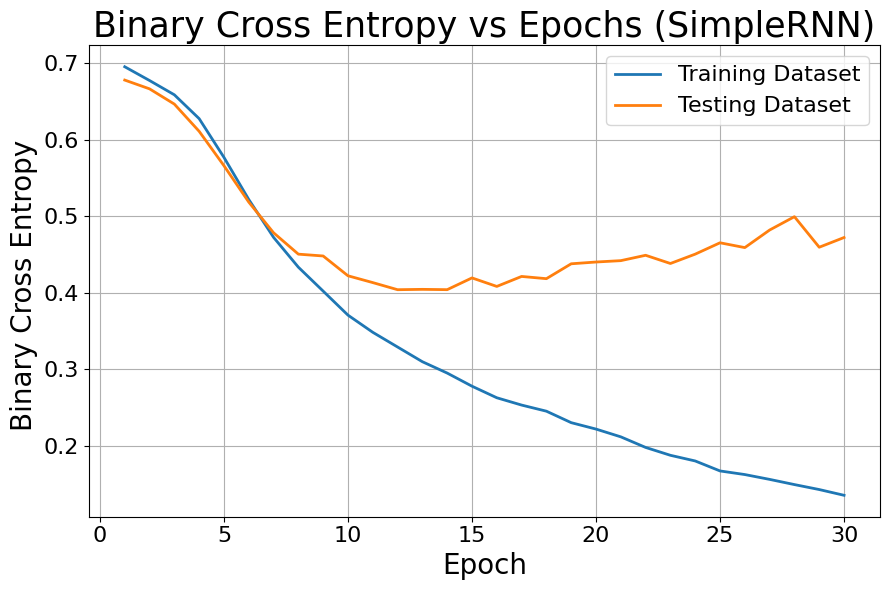

In [ ]:
iterations = np.arange(1, len(training_ds_loss_history)+1)
plt.figure(figsize=(9, 6))
plt.plot(iterations, training_ds_loss_history, linewidth=2, label='Training Dataset')
plt.plot(iterations, testing_ds_loss_history, linewidth=2, label='Testing Dataset')
plt.title('Binary Cross Entropy vs Epochs (SimpleRNN)', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Binary Cross Entropy ', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.savefig('bce_rnn.png', dpi=300)
plt.show()

# GRU

In [97]:
model = Sequential()
model.add(embedding_layer)
model.add(GRU(units=8, return_sequences=False))  # GRU layer with 8 units
model.add(Dense(1, activation='sigmoid'))  # Binary classification output layer

# 3. Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 4. Train the model
history = model.fit(X_train, y_train, validation_data=[X_test, y_test], batch_size=64, epochs=30)
training_ds_loss_history = history.history['loss']
testing_ds_loss_history = history.history['val_loss']

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.4980 - loss: 0.6934 - val_accuracy: 0.4900 - val_loss: 0.6923
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5456 - loss: 0.6913 - val_accuracy: 0.4950 - val_loss: 0.6926
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5123 - loss: 0.6899 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5125 - loss: 0.6887 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5173 - loss: 0.6872 - val_accuracy: 0.5700 - val_loss: 0.6931
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5563 - loss: 0.6853 - val_accuracy: 0.5550 - val_loss: 0.6931
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5822 - loss: 0.6827 - val_accuracy: 0.5700 - val_loss: 0.6929
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5693 - loss: 0.6841 - val_accuracy: 0.5550 - v

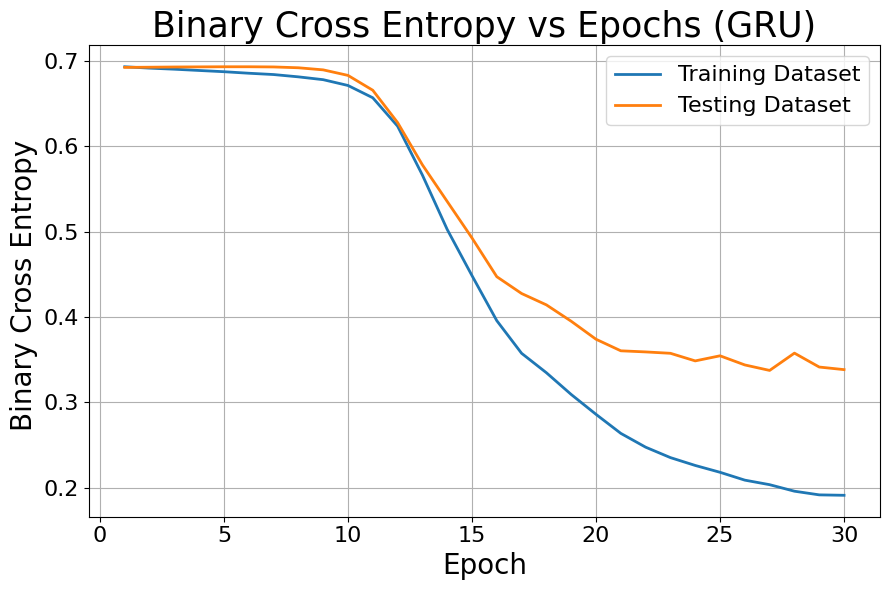

In [ ]:
iterations = np.arange(1, len(training_ds_loss_history)+1)
plt.figure(figsize=(9, 6))
plt.plot(iterations, training_ds_loss_history, linewidth=2, label='Training Dataset')
plt.plot(iterations, testing_ds_loss_history, linewidth=2, label='Testing Dataset')
plt.title('Binary Cross Entropy vs Epochs (GRU)', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Binary Cross Entropy ', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.savefig('bce_gru.png', dpi=300)
plt.show()

# LSTM

In [99]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=8, return_sequences=False))  # LSTM layer with 8 units
model.add(Dense(1, activation='sigmoid'))  # Binary classification output layer

# 3. Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 4. Train the model
history = model.fit(X_train, y_train, validation_data=[X_test, y_test], batch_size=64, epochs=30)
training_ds_loss_history = history.history['loss']
testing_ds_loss_history = history.history['val_loss']

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.4934 - loss: 0.6925 - val_accuracy: 0.5200 - val_loss: 0.6928
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5374 - loss: 0.6897 - val_accuracy: 0.5750 - val_loss: 0.6905
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6133 - loss: 0.6841 - val_accuracy: 0.5800 - val_loss: 0.6863
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6228 - loss: 0.6756 - val_accuracy: 0.6500 - val_loss: 0.6747
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6942 - loss: 0.6525 - val_accuracy: 0.6850 - val_loss: 0.6470
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7242 - loss: 0.6218 - val_accuracy: 0.7200 - val_loss: 0.6086
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7461 - loss: 0.5665 - val_accuracy: 0.7550 - val_loss: 0.5690
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7903 - loss: 0.5167 - val_accuracy: 0.7850 - v

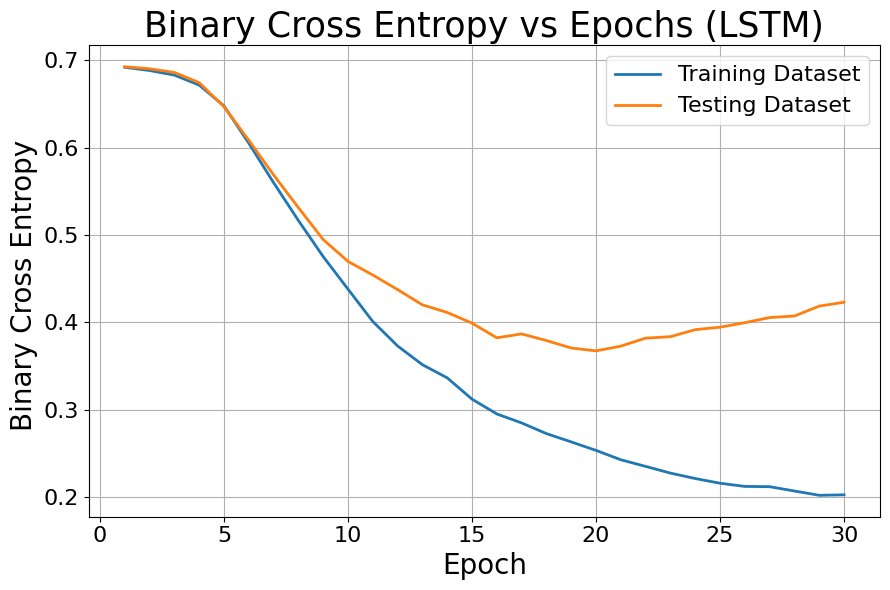

In [ ]:
iterations = np.arange(1, len(training_ds_loss_history)+1)
plt.figure(figsize=(9, 6))
plt.plot(iterations, training_ds_loss_history, linewidth=2, label='Training Dataset')
plt.plot(iterations, testing_ds_loss_history, linewidth=2, label='Testing Dataset')
plt.title('Binary Cross Entropy vs Epochs (LSTM)', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Binary Cross Entropy ', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.savefig('bce_lstm.png', dpi=300)
plt.show()